# Traitements des donnees

## 1) installation des dependances

In [132]:
# !pip install dico/fr_core_news_md-3.7.0-py3-none-any.whl
# !pip install pandas
# !pip install fuzzywuzzy
# !pip install python-Levenshtein
# !pip install regex

## 2) Importation des libraries

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import os
from urllib.parse import urlparse
from fuzzywuzzy import fuzz
import platform

## 3) Chargement du modèle spaCy

In [134]:
# Charger le modèle spaCy
nlp = spacy.load("fr_core_news_md")

## 4) Recuperation, fusion et preparations des datasets brutes

In [135]:
if platform.system() == 'Windows':
    folder = f'D:\\Bureau\\MemoiresStages\\Travaux_techniques\\Scrapping\\Datasets\\Juin\\20_juin\\CoinAfriqueCi_pages_20_juin\\o'
else:
    folder = f'/mnt/d/Bureau/MemoiresStages/Travaux_techniques/Scrapping/Datasets/Juin'
    
# Fonction pour obtenir tous les fichiers CSV dans un dossier et ses sous-dossiers
def get_all_csv_files(folder):
    csv_files = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    print("Les traitements sont en cours, cela pourrait prendre quelques minutes...")
    return csv_files

# Obtenir la liste de tous les fichiers CSV
file_paths = get_all_csv_files(folder)

# Charger et fusionner les fichiers
df_list = [pd.read_csv(file) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)


# Convertir toutes les valeurs en minuscules pour les colonnes de type str, sauf pour les colonnes spécifiées
columns_to_exclude = ['superficie', 'nb_pieces', 'nb_salle_de_bain', 'scraping_date', 'link']
df = df.apply(lambda col: col.str.lower() if col.name not in columns_to_exclude and col.dtype == 'object' else col)

# Filtrer les lignes en fonction de la longueur de la description
seuil_longueur_description = 200
df = df[df['description'].str.len() >= seuil_longueur_description]

Les traitements sont en cours, cela pourrait prendre quelques minutes...


## 5) Creation des variables 'site' et 'date'

In [136]:
# Fonction pour extraire le nom de domaine à partir de l'URL
def extract_site(link):
    try:
        return urlparse(link).netloc
    except:
        return None

# Ajouter la colonne 'site' en extrayant le nom de domaine de la colonne 'link'
if 'link' in df.columns:
    df['site'] = df['link'].apply(extract_site)
    
    
# Fonction pour extraire la date à partir de 'scraping_date'
def extract_date(scraping_date):
    try:
        return scraping_date.split(' ')[0]
    except:
        return None

# Ajouter la colonne 'date' en extrayant la date de 'scraping_date'
if 'scraping_date' in df.columns:
    df['date'] = df['scraping_date'].apply(extract_date)

# Convertir la colonne 'date' au format datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')

## 6) traitement de la variable prix et superficie

In [137]:
# Supprimer les lignes où 'price' contient des indications de paiement journalier
df = df[~df['price'].str.contains(r'par jour|/ jour', case=False, na=False)]

# Supprimer les lignes avec des prix manquants
df = df.dropna(subset=['price'])


# Fonction pour nettoyer et convertir les valeurs de 'price' en format numérique
def clean_price(price):
    # Extraire les chiffres de la chaîne de caractères
    price = re.sub(r'[^\d]', '', str(price))
    # Convertir en entier
    return float(price) if price.isdigit() else None

# Fonction pour nettoyer et convertir les valeurs de 'superficie' en format float
def clean_superficie(superficie):
    # Retirer toutes les occurrences de "m2" et extraire les chiffres
    superficie = re.sub(r'\s*m2\s*', '', str(superficie), flags=re.IGNORECASE)
    # Convertir en float
    try:
        return float(superficie)
    except ValueError:
        return None
    

# Appliquer la fonction de nettoyage sur la colonne 'price'
df['price'] = df['price'].apply(clean_price)
# Supprimer les lignes avec un prix inférieur à 20000
df = df[df['price'] > 9999]

# Appliquer la fonction de nettoyage sur la colonne 'superficie' et renommer la colonne
if 'superficie' in df.columns:
    df['superficie_m2'] = df['superficie'].apply(clean_superficie)
    df.drop(columns=['superficie'], inplace=True)

## 7) Suppression des lignes non pertinentes (ventes, entrepots, etc.)

In [138]:
# Détection et suppression des lignes évoquant la vente, entrepôt ou avec un prix > 10000000
vente_keywords = ['vente', 'vendre', 'à vendre', 'a vendre', 'prix de vente', 'coût de vente', 'cout de vente']
entrepot_keywords = ['entrepôt', 'entrepot', 'hotel', 'hôtel', 'saisonnière', 'saisonniere', 'bureau']

def is_for_sale_or_entrepot(description, price):
    if isinstance(description, str) and (any(keyword in description for keyword in vente_keywords) or any(keyword in description for keyword in entrepot_keywords)):
        return True
    if price and price > 6000000:
        return True
    return False

df = df[~df.apply(lambda row: is_for_sale_or_entrepot(row['description'], row['price']), axis=1)]


# Supprimer les lignes contenant plusieurs biens immobiliers dans le titre
multiple_properties_regex1 = r'appartements|studios|maisons|villas|bureaux'
df = df[~df['title'].str.contains(multiple_properties_regex1, case=False, na=False)]

# Supprimer les lignes contenant plusieurs biens immobiliers dans le titre
multiple_properties_regex2 = r','
df = df[~df['title'].str.contains(multiple_properties_regex2, case=False, na=False)]

# Supprimer les lignes contenant "et" dans le titre
df = df[~df['title'].str.contains(r'\bet\b', case=False, na=False)]

# Supprimer les lignes contenant "terrain" dans le titre
df = df[~df['title'].str.contains(r'\bterrain\b', case=False, na=False)]


## il s'agit de supprimer les lignes ou les prix sont donnees par jour et non par mois et pour lequelles on ne retrouve pas dans la concatenation de title et description
# Définir le seuil
seuil = 50000

# Expressions régulières pour détecter les valeurs de prix et les termes indiquant un prix par jour
jour_patterns = r"(/|la|par)\s*(nuitée|nuit|jour)"
price_patterns = lambda price: fr"{price}|{price // 1000}k|{price}f|{price}fcfa|{price}f cfa|{price // 1000}\s*000"

def should_remove_row(row, seuil):
    price = row['price']
    title_desc = f"{row['title']} {row['description']}"
    
    # Si le prix est inférieur au seuil, on commence les vérifications
    if price < seuil:
        # Rechercher la valeur de price sous différentes formes
        price_pattern = price_patterns(price)
        match = re.search(price_pattern, title_desc)
        if match:
            # Vérifier si elle est associée à une indication de tarif journalier
            price_index = match.end()  # Position de la fin de la correspondance du prix
            # Vérifier les mots qui suivent immédiatement la valeur trouvée
            after_price_text = title_desc[price_index:price_index+20]  # Prendre les 20 caractères suivants
            if re.search(jour_patterns, after_price_text):
                # Rechercher d'autres valeurs numériques plus élevées dans la chaîne
                higher_prices = [int(p.replace(' ', '').replace('k', '000').replace('f', '').replace('fcfa', '')) for p in re.findall(r'\b\d{1,3}(?:\s?\d{3})*f?\b', title_desc)]
                higher_prices = [p for p in higher_prices if p > price]
                if higher_prices:
                    # Vérifier si une de ces valeurs est mensuelle
                    for hp in higher_prices:
                        hp_pattern = price_patterns(hp)
                        match_hp = re.search(hp_pattern, title_desc)
                        if match_hp:
                            hp_index = match_hp.end()
                            after_hp_text = title_desc[hp_index:hp_index+20]
                            if not re.search(jour_patterns, after_hp_text):
                                return False  # On garde la ligne car on a trouvé un prix mensuel
                return True  # Aucune valeur mensuelle trouvée, on supprime la ligne
            else:
                return False  # La valeur n'est pas indiquée comme journalière, on garde la ligne
        else:
            return True  # Aucune correspondance avec le prix, on supprime la ligne
    return False  # Prix au-dessus du seuil, on garde la ligne

# Appliquer cette fonction pour supprimer les lignes indésirables
df = df[~df.apply(should_remove_row, axis=1, seuil=seuil)]


# Expression régulière pour identifier les types de logement
housing_types_pattern = r'(appartement|villa|studio|penthouse|maison|duplex)'

# Filtrer les lignes où le title ne contient pas les types de logement spécifiés
df = df[df['title'].str.contains(housing_types_pattern, case=False, na=False)]



C:\Users\Wilfried KOMENAN\AppData\Local\Temp\ipykernel_14792\3415900348.py:81: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[df['title'].str.contains(housing_types_pattern, case=False, na=False)]


## 8) Traitements de la variable salle de bain

In [139]:
# Fonction pour nettoyer la colonne 'nb_salle_de_bain'
def clean_nb_salle_de_bain(nb_salle_de_bain):
    if pd.isna(nb_salle_de_bain):
        return None
    # Utiliser une expression régulière pour extraire le nombre
    match = re.search(r'\d+', nb_salle_de_bain)
    if match:
        return int(match.group())
    return None

# Convertir toute la colonne 'nb_salle_de_bain' en string avant de faire le traitement
if 'nb_salle_de_bain' in df.columns:
    df['nb_salle_de_bain'] = df['nb_salle_de_bain'].astype(str)
    df['nb_salle_de_bain'] = df['nb_salle_de_bain'].apply(clean_nb_salle_de_bain)

# Convertir la colonne 'nb_salle_de_bain' en type Int64
df['nb_salle_de_bain'] = df['nb_salle_de_bain'].astype('Int64')


## 9) suppression des doublons

In [140]:
# Fonction pour gérer les doublons primaires
def remove_primary_duplicates(df):
    primary_columns = [col for col in df.columns if col not in ['scraping_date', 'date']]
    duplicates = df[df.duplicated(subset=primary_columns, keep=False)]
    primary_duplicates_count = duplicates.shape[0]
    print(f"Nombre de doublons primaires détectés: {primary_duplicates_count}")
    df = df.drop_duplicates(subset=primary_columns, keep='first')
    return df, duplicates

# Appliquer la suppression des doublons primaires
df, primary_duplicates = remove_primary_duplicates(df)


# Fonction pour gérer les doublons secondaires
def remove_secondary_duplicates(df):
    df['description_clean'] = df['description'].apply(lambda x: re.sub(r'\W+', ' ', str(x)))
    duplicates = set()
    seen = set()

    for i, row in df.iterrows():
        if i in seen:
            continue
        for j, other_row in df.iterrows():
            if i != j and j not in seen:
                similarity = fuzz.token_set_ratio(row['description_clean'], other_row['description_clean'])
                if similarity > 98:
                    duplicates.add(j)
                    seen.add(j)
                    break  # Exit the inner loop to ensure only one duplicate is removed

    secondary_duplicates_count = len(duplicates)
    print(f"Nombre de doublons secondaires détectés: {secondary_duplicates_count}")

    duplicates_list = list(duplicates)
    secondary_duplicates = df.loc[duplicates_list]
    df = df.drop(duplicates_list)
    df.drop(columns=['description_clean'], inplace=True)
    return df, secondary_duplicates

# Appliquer la suppression des doublons secondaires
df, secondary_duplicates = remove_secondary_duplicates(df)

print(f'Restants {len(df)}')

Nombre de doublons primaires détectés: 139
Nombre de doublons secondaires détectés: 18
Restants 115


## Creation des granularite de la variable localisation :
### granularite ici = region, ville, commune, quartier

In [141]:
# Dictionnaire pour les grappes et leurs régions associées
grappe_to_region = {
    'abidjan': ['abidjan'],
    'nord': [r'bafing', r'bagou(é|e)', r'folon', r'kabadougou', r'poro', r'tchologo', r'worodougou'],
    'centre': [r'b(é|e)lier', r'gb(ê|e)k(ê|e)', r'hambol', r'iffou', r'marahou(é|e)', r'moronou', r'n’zi', r'yamoussoukro \(district autonome\)'],
    'est': [r'bounkani', r'gontougo', r'ind(é|e)ni(é|e)-djuablin', r'm(é|e)', r'sud-como(é|e)', r'zanzan'],
    'ouest': [r'agn(é|e)by-tiassa', r'b(é|e)r(é|e)', r'cavally', r'gb(ô|o)kl(é|e)', r'g(ô|o)h', r'grands-ponts', r'gu(é|e)mon', r'haut-sassandra', r'l(ô|o)h-djiboua', r'nawa', r'san-p(é|e)dro', r'tonkpi']
}


region_to_ville = {
    # Région d'Abidjan
    'abidjan': ['abidjan'],
    # Autres régions
    'bafing': ['touba'],
    'bagoué': [r'boundiali'],
    'folon': ['minignan'],
    'kabadougou': [r'odienn(é|e)'],
    'poro': ['korhogo'],
    'tchologo': [r'ferkess(é|e)dougou'],
    'worodougou': [r's(é|e)gu(é|e)la'],
    'bélier': [r'yamoussoukro'],
    'gbêkê': [r'bouak(é|e)'],
    'hambol': [r'katiola'],
    'iffou': [r'daoukro'],
    'marahoué': [r'bouafl(é|e)'],
    'moronou': [r'bongouanou'],
    'n’zi': [r'dimbokro'],
    'bounkani': [r'bouna'],
    'gontougo': [r'bondoukou'],
    'indénié-djuablin': [r'abengourou'],
    'mé': [r'adzop(é|e)'],
    'sud-comoé': [r'aboisso'],
    'agnéby-tiassa': [r'agboville'],
    'béré': [r'mankono'],
    'cavally': [r'guiglo'],
    'gbôklé': [r'sassandra'],
    'gôh': [r'gagnoa'],
    'grands-ponts': [r'dabou'],
    'guémon': [r'du(é|e)kou(é|e)'],
    'haut-sassandra': [r'daloa'],
    'lôh-djiboua': [r'divo'],
    'nawa': [r'soubr(é|e)'],
    'san-pédro': [r'san-p(é|e)dro'],
    'tonkpi': [r'man']
}


# Dictionnaire pour les communes et leurs quartiers associés (seulement pour Abidjan)
commune_to_quartier = {
    # Abobo
    'abobo': [r'abobo baoul(é|e)', r'abobo doum(é|e)', r'pk18', r'anonkoua kout(é|e)', r'avocatier', r'belleville', r'derri(è|e)re rails', r'n’dotr(é|e)', r'samak(é|e)'],
    # Adjamé
    'adjamé': [r'williamsville', r'bracodi', r'ind(é|e)ni(é|e)', r'adjam(é|e) 220 logements', r'adjam(é|e) village', r'libert(é|e)', r'habitat', r'fraternit(é|e)'],
    # Attécoubé
    'attécoubé': [r'banco', r'abobodoum(é|e)', r'locodjro', r'mossikro', r'agban', r'anonkoua', r'att(é|e)coub(é|e) village'],
    # Cocody
    'cocody': [r'angr(é|e)', r'abatta', r'rivi(é|e)ra', r'rivi(é|e)ra 1', r'rivi(é|e)ra 2', r'rivi(é|e)ra 3', r'rivi(é|e)ra 4', r'palmeraie', r'deux plateaux', r'danga', r'mermoz', r'vallon', r'cit(é|e) des arts', r'cit(é|e) rouge', r'ambassade', r'golf', r'faya'],
    # Koumassi
    'koumassi': [r'divo', r'remblais', r'prodomo', r'campement', r'sicogi', r'grand campement', r'zone industrielle'],
    # Marcory
    'marcory': [r'zone 4', r'bi(é|e)try', r'anoumabo', r'hibiscus', r'r(é|e)sidentiel', r'zone 3', r'zone 4c'],
    # Le Plateau
    'le plateau': [r'plateau ind(é|e)ni(é|e)', r'plateau dokui', r'plateau vallon', r'plateau centre', r'plateau nord', r'plateau sud'],
    'plateau': [r'plateau ind(é|e)ni(é|e)', r'plateau dokui', r'plateau vallon', r'plateau centre', r'plateau nord', r'plateau sud'],
    # Port-Bouët
    'port-bouët': [r'gonzagueville', r'vridi', r'adjouffou', r'jean folly', r'port', r'petit bassam', r'vridi canal'],
    # Treichville
    'treichville': [r'arras', r'belleville', r'zone 3', r'avenue 16', r'avenue 8', r'avenue 12', r'avenue 21'],
    # Yopougon
    'yopougon': [r'niangon', r'sid(é|e)ci', r'toits rouges', r'andokoi', r'selmer', r'maroc', r'kout(é|e)', r'wassakara', r'sicogi', r'gesco']
}

# Dictionnaire pour les villes et leurs communes (seulement pour Abidjan)
ville_to_commune = {
    'abidjan': ['abobo', 'adjamé', 'attécoubé', 'cocody', 'koumassi', 'marcory', 'le plateau', 'port-bouët', 'treichville', 'yopougon', 'anyama', 'bingerville', 'songon']
}



# Fonction pour extraire les informations de localisation
def extract_location_info(text):
    # Convertir en minuscules et diviser le texte en tokens
    tokens = re.findall(r'\b\w+\b', text)
    
    grappe, region, ville, commune, quartier = None, None, None, None, None

    # Recherche du quartier et déduction de la commune et de la région pour Abidjan
    for commune_key, quartiers in commune_to_quartier.items():
        for quartier_key in quartiers:
            quartier_tokens = re.findall(r'\b\w+\b', quartier_key)
            if all(token in tokens for token in quartier_tokens):
                quartier = quartier_key
                commune = commune_key
                ville = 'abidjan'
                region = 'abidjan'
                grappe = 'abidjan'
                return grappe, region, ville, commune, quartier

    # Recherche de la commune et déduction de la région pour Abidjan
    for commune_key in ville_to_commune['abidjan']:
        commune_tokens = re.findall(r'\b\w+\b', commune_key)
        if all(token in tokens for token in commune_tokens):
            commune = commune_key
            ville = 'abidjan'
            region = 'abidjan'
            grappe = 'abidjan'
            return grappe, region, ville, commune, quartier

    # Recherche de la ville et déduction de la région
    for region_key, villes in region_to_ville.items():
        for ville_key in villes:
            ville_tokens = re.findall(r'\b\w+\b', ville_key)
            if all(token in tokens for token in ville_tokens):
                ville = ville_key
                region = region_key
                for grappe_key, regions in grappe_to_region.items():
                    if region in regions:
                        grappe = grappe_key
                return grappe, region, ville, None, None

    return grappe, region, ville, commune, quartier

# Appliquer la fonction à chaque ligne du DataFrame
df['grappe'], df['region'], df['ville'], df['commune'], df['quartier'] = zip(*df.apply(
    lambda row: extract_location_info(f"{row['title']} {row['localisation']} {row['description']}"), axis=1))


df = df.dropna(subset=['grappe', 'region'])



## 10) Traitement du nombre de pieces

In [142]:
# Fonction pour nettoyer la colonne 'nb_pieces' et la convertir en int
def clean_nb_pieces(nb_pieces):
    if pd.isna(nb_pieces):
        return None
    # Extraire les chiffres de la chaîne de caractères et les convertir en entier
    match = re.search(r'\d+', str(nb_pieces))
    if match:
        return int(match.group())
    return None

# Appliquer la fonction pour nettoyer 'nb_pieces'
df['nb_pieces'] = df['nb_pieces'].apply(clean_nb_pieces)


def extract_nb_pieces_if_different(row):
    # Extraire le nombre de pièces du titre
    match = re.search(r'\b(\d+)\s*(pi[eè]ces?|pcs?)\b', row['title'])
    if match:
        nb_pieces_title = int(match.group(1))
        # Vérifier si le nombre de pièces extrait du titre est différent de celui existant
        if row['nb_pieces'] != nb_pieces_title:
            return nb_pieces_title
    # Cas particulier pour "studio" ou "chambre salon"
    if "studio" in row['title'].lower() or "chambre salon" in row['title'].lower():
        return 1
    return row['nb_pieces']

# Appliquer la fonction sur chaque ligne du DataFrame
if 'title' in df.columns and 'nb_pieces' in df.columns:
    df['nb_pieces'] = df.apply(extract_nb_pieces_if_different, axis=1)

# Convertir 'nb_pieces' en int (si cela est nécessaire)
df['nb_pieces'] = df['nb_pieces'].astype('Int64')


def supprimer_lignes_nb_pieces_manquant(df):
    # Définir le motif regex
    motif = re.compile(r'\b(\d+)\s*(pi[eè]ces?|pcs?)\b')

    def garder_ligne(row):
        # Vérifier si 'nb_pieces' est manquant
        if pd.isna(row['nb_pieces']):
            # Vérifier si le motif n'est pas trouvé dans la description
            if not motif.search(str(row['description'])):
                return False
        return True

    # Appliquer la fonction pour filtrer les lignes
    df = df[df.apply(garder_ligne, axis=1)]
    return df

# Appliquer la fonction au dataframe
df = supprimer_lignes_nb_pieces_manquant(df)


def imputer_nb_pieces(df):
    # Définir le motif regex pour trouver le nombre de pièces
    motif = re.compile(r'\b(\d+)\s*(pi[eè]ces?|pcs?)\b')

    def imputer_ligne(row):
        # Vérifier si 'nb_pieces' est manquant
        if pd.isna(row['nb_pieces']):
            # Rechercher le motif dans la description
            match = motif.search(str(row['description']))
            if match:
                # Extraire et retourner le nombre de pièces
                row['nb_pieces'] = int(match.group(1))
        return row

    # Appliquer la fonction pour imputer les valeurs manquantes de 'nb_pieces'
    df = df.apply(imputer_ligne, axis=1)
    return df

# Appliquer la fonction au dataframe
df = imputer_nb_pieces(df)

## 11) Traitement du type d'immobilier

In [143]:
# Fonction pour déterminer le type d'immobilier
def classify_immobilier(row):
    text = ' '.join([row['title'], row['description']])
    text2 = str(row['nb_pieces'])
    if re.search(r'1', text2, re.IGNORECASE):
        return 'studio'
    if re.search(r'\b(duplex|triplex)\b', text, re.IGNORECASE):
        return 'duplex'
    if re.search(r'\b(villa)\b', text, re.IGNORECASE):
        return 'villa'
    if re.search(r'\b(appartement|penthouse)\b', text, re.IGNORECASE):
        return 'appartement'
    return 'maison'

# Appliquer la fonction pour créer la colonne 'type_d_immobilier'
df['type d\'immobilier'] = df.apply(classify_immobilier, axis=1)


# Mapping dictionary to standardize type d'immobilier
harmonization_map = {
    r'appartements': 'appartement',
    r'penthouse': 'appartement',
    r'maisons': 'maison',
    r'villas': 'villa',
    r'studios': 'studio',
    r'duplex': 'duplex'
}

# Function to harmonize type d'immobilier
def harmonize_type_immobilier(type_immobilier):
    if pd.isna(type_immobilier):
        return None
    for pattern, replacement in harmonization_map.items():
        if re.search(pattern, type_immobilier, re.IGNORECASE):
            return replacement
    return type_immobilier

# Apply the harmonization function to the 'type d'immobilier' column
df['type d\'immobilier'] = df['type d\'immobilier'].apply(harmonize_type_immobilier)

df = df.dropna(subset=['type d\'immobilier'])


## 12) Classification des logements

In [144]:
# Fonction pour déterminer si les toilettes sont internes
def has_toilettes_internes(description):
    return 0 if re.search(r"(toilette|wc|douche|salle d'eau) externe", description, re.IGNORECASE) else 1

# Fonction pour déterminer si la cour est commune
def has_cours_commune(description):
    return 1 if re.search(r"cours commune", description, re.IGNORECASE) else 0

# Appliquer les fonctions pour créer les nouvelles variables
df['Avec_eau'] = 1
df['Avec_electricite'] = 1
df['Materiaux_en_dur'] = 1
df['Toilettes_internes'] = df['description'].apply(has_toilettes_internes)
df['cours_commune'] = df['description'].apply(has_cours_commune)


# Définir la liste des quartiers chics
quartiers_chics = [
    r'angré', 
    r'riviera', 
    r'riviera 1', 
    r'riviera 2', 
    r'riviera 3', 
    r'riviera 4', 
    'palmeraie', 
    'deux plateaux', 
    'danga', 
    'mermoz', 
    r'vallon', 
    'cité des arts', 
    'zone 4', 
    'biétry', 
    'hibiscus', 
    'résidentiel', 
    'plateau',
    'le plateau',
    'ambassade',
    'golf',
    'faya',
    'residentiel'
]

# Fonction pour déterminer si la localisation est dans un quartier chic
def is_quartier_chic(quartier):
    if pd.isna(quartier): 
        return 0
    quartier = str(quartier)
    for quartier1 in quartiers_chics:
        if re.search(quartier1, quartier, re.IGNORECASE):
            return 1
    return 0

# Appliquer la fonction pour créer la variable 'quartier_chic'
df['quartier_chic'] = df['quartier'].apply(is_quartier_chic)

# Fonction pour classifier le nombre de pièces
def classify_nb_pieces(nb_pieces):
    if nb_pieces == 1:
        return r'1 pièce'
    elif 2 <= nb_pieces <= 3:
        return r'2 et 3 pièces'
    elif nb_pieces >= 4:
        return r'4 pièces et plus'
    else:
        return 'non spécifié'

# Appliquer la fonction pour créer la colonne 'nb_pieces_classe'
df['nb_pieces_classe'] = df['nb_pieces'].apply(classify_nb_pieces)

code_mapping = {
    
#'type', 'pieces', 'eau', 'elec', 'en_dur', 'wc', 'cours_com', 'quartier'
    
    # Loyer brut mensuel d'une chambre dans une baraque sans abonnement electrique per
    (r'chambre', r'1 pièce', r'1', r'0', r'0', r'0', r'1', r'0'): "401000001",
    (r'chambre', r'1 pièce', r'0', r'0', r'0', r'0', r'1', r'0'): "401000001",
    (r'chambre', r'1 pièce', r'1', r'0', r'0', r'0', r'0', r'0'): "401000001",
    (r'chambre', r'1 pièce', r'0', r'0', r'0', r'0', r'0', r'0'): "401000001",
    
    # Loyer d'un appartement moderne, Avec/sans eau: avec, Avec/sans electricité: avec
    (r'appartement', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'1', r'1'): "401000002",
    (r'appartement', r'2 et 3 pièces', r'1', r'1', r'1', r'0', r'1', r'1'): "401000002",
    (r'appartement', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'0', r'1'): "401000002",
    (r'appartement', r'2 et 3 pièces', r'1', r'1', r'1', r'0', r'0', r'1'): "401000002",
    (r'appartement', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'1', r'0'): "401000002",
    (r'appartement', r'2 et 3 pièces', r'1', r'1', r'1', r'0', r'1', r'0'): "401000002",
    (r'appartement', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'0', r'0'): "401000002",
    (r'appartement', r'2 et 3 pièces', r'1', r'1', r'1', r'0', r'0', r'0'): "401000002",
    #
    (r'appartement', r'4 pièces et plus', r'1', r'1', r'1', r'1', r'1', r'1'): "401000002",
    (r'appartement', r'4 pièces et plus', r'1', r'1', r'1', r'0', r'1', r'1'): "401000002",
    (r'appartement', r'4 pièces et plus', r'1', r'1', r'1', r'1', r'0', r'1'): "401000002",
    (r'appartement', r'4 pièces et plus', r'1', r'1', r'1', r'0', r'0', r'1'): "401000002",
    (r'appartement', r'4 pièces et plus', r'1', r'1', r'1', r'1', r'1', r'0'): "401000002",
    (r'appartement', r'4 pièces et plus', r'1', r'1', r'1', r'0', r'1', r'0'): "401000002",
    (r'appartement', r'4 pièces et plus', r'1', r'1', r'1', r'1', r'0', r'0'): "401000002",
    (r'appartement', r'4 pièces et plus', r'1', r'1', r'1', r'0', r'0', r'0'): "401000002",

    # Loyer brut mensuel d'une maison de 2 à  3 pièces dans une cour commune avec toile
    (r'maison', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'1', r'1'): "401000003",
    (r'maison', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'1', r'0'): "401000003",
    
    # Loyer brut mensuel d'un logement de 2 à  3 pièces dans une cour commune sans toil
    (r'maison', r'2 et 3 pièces', r'1', r'1', r'1', r'0', r'1', r'1'): "401000004",
    (r'maison', r'2 et 3 pièces', r'1', r'1', r'1', r'0', r'1', r'0'): "401000004",
    
    # Loyer d'une maison, Cour commune: Non, Matériaux: en dur, toilettes internes: oui
    (r'maison', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'0', r'1'): "401000005",
    (r'maison', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'0', r'0'): "401000005",
    
    
    # Loyer d'une maison duplex , Matériaux: en dur, toilettes internes: oui 1 ou plusieurs, type de quartier : chic.
    (r'duplex', r'4 pièces et plus', r'1', r'1', r'1', r'1', r'0', r'1'): "401000006",
    (r'duplex', r'4 pièces et plus', r'1', r'1', r'1', r'1', r'0', r'0'): "401000006",
    
    # Loyer d'un logement, Type: studio, Nombre de chambre à coucher:  1, Matériaux;  dur, Cour commune: Non,  Toilettes internes: Oui. Autres caractéristiques: à plusieurs appartements,
    (r'studio', r'1 pièce', r'1', r'1', r'1', r'1', r'0', r'1'): "401000007",
    (r'appartement', r'1 pièce', r'1', r'1', r'1', r'1', r'0', r'1'): "401000007",
    (r'studio', r'1 pièce', r'1', r'1', r'1', r'1', r'0', r'0'): "401000007",
    (r'appartement', r'1 pièce', r'1', r'1', r'1', r'1', r'0', r'0'): "401000007",
    
    # Loyer d'un logement, Type: studio, Nombre de chambre à coucher:  1, Matériaux;  dur, Cour commune: Non,  Toilettes internes: Oui. Autres caractéristiques: à plusieurs appartements,
    (r'studio', r'1 pièce', r'1', r'1', r'1', r'1', r'0', r'1'): "401000008",
    (r'studio', r'1 pièce', r'1', r'1', r'1', r'1', r'0', r'0'): "401000008",

    # Loyer d'un logement, Type: studio, Nombre de chambre à coucher:  1, Matériaux;  dur, Cour commune: Oui,  Toilettes internes: non, Autres caractéristiques: maison basse, à plusieurs appartements, type de quartier: populaire
    (r'studio', r'1 pièce', r'1', r'1', r'1', r'0', r'1', r'0'): "401000009",

    
    
    #Loyer Villa moderne, clôture: Oui, cours: avec, sanitaires internes: Oui, habitée par un seul locataire: Oui, Type de quartier: résidentiel
    (r'villa', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'0', r'1'): "401000010", 
    (r'maison', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'0', r'1'): "401000010",
    (r'villa', r'4 pièces et plus', r'1', r'1', r'1', r'1', r'0', r'1'): "401000010", 
    (r'maison', r'4 pièces et plus', r'1', r'1', r'1', r'1', r'0', r'1'): "401000010",
  
    
    #Loyer Villa moderne, clôture: Oui, cours: avec, sanitaires internes: Oui, habitée par un seul locataire: Oui, Type de quartier: populaire
    (r'villa', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'0', r'0'): "401000011",
    (r'maison', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'0', r'0'): "401000011",
    (r'villa', r'4 pièces et plus', r'1', r'1', r'1', r'1', r'0', r'0'): "401000011",
    (r'maison', r'4 pièces et plus', r'1', r'1', r'1', r'1', r'0', r'0'): "401000011",
}


# Fonction pour obtenir le code de classification
def get_classification_code(row, code_mapping):
    key = (
        row['type d\'immobilier'],
        row['nb_pieces_classe'],
        str(row['Avec_eau']),
        str(row['Avec_electricite']),
        str(row['Materiaux_en_dur']),
        str(row['Toilettes_internes']),
        str(row['cours_commune']),
        str(row['quartier_chic'])
    )
    code = code_mapping.get(key, None)
    if code is None:
        print(f"Key not found: {key}")
    return code


# Appliquer la fonction pour créer la colonne 'code_var 2014'
df['code_var 2014'] = df.apply(get_classification_code, axis=1, code_mapping=code_mapping)


df = df.dropna(subset=['code_var 2014'])


Key not found: ('duplex', '2 et 3 pièces', '1', '1', '1', '1', '0', '0')


## Creation de variables d'externalites

In [145]:
# Définir les dictionnaires de mots regroupés
commodities = {
    'wifi': [r'wifi', r'internet', r'connexion', r'fibre optique'],
    'jardin': [r'jardin(\.locat\d+)?'],
    'meubler': [r'meubl(er|é|e)'],
    'climatisation': [r'climat(isé|isation|iseur)', r'air conditionner', r'split'],
    'garage': [r'garage'],
    'balcon': [r'balcon'],
    'sécuriser': [r'sécur(is|it|is)(er|e|é)'],
    'étage': [r'étage'],
    'parking': [r'parking'],
    'douche': [r'douche'],
    'séjour': [r'séjour', r'sejour'],
    'équiper': [r'équip(er|é|e|ée|ement)'],
    'placard': [r'placard'],
    'salle': [r'salle'],
    'manger': [r'manger'],
    'bureau': [r'bureau'],
    'piscine': [r'piscine'],
    'gardien': [r'gardi(en|en)', r'garde'],
    'électrogène': [r'électrogène'],
    'four': [r'four'],
    'cinéma': [r'cinéma', r'netflix'],
    'ascenseur': [r'ascenseur'],
    'double vitrage': [r'double vitrage'],
    'terrasse': [r'terrasse'],
    'toilette': [r'toilette', r'wc'],
    'buanderie': [r'buanderie'],
    'chauffe': [r'chauff(e|e-eau)'],
    'cuisine': [r'cuisine']
}

natural_externalities = {
    'bord_de_mer': [r'plage', r'mer', r'océan'],
    'forêt': [r'for(ê|e)t'],
    'parc': [r'parc'],
    'montagne': [r'montagne'],
    'rivière': [r'rivi(è|e)re'],
    'lac': [r'lac']
}

artificial_externalities = {
    'zone_commerciale': [r'centre commercial', r'marché', r'zone commerciale'],
    'pharmacie': [r'pharmacie'],
    'restaurant': [r'restaurant', r'resto'],
    'bar': [r'bar', r'maquis'],
    'ambassade': [r'ambassade'],
    'école': [r'écol(e|es)', r'crèch(e|es)', r'lycé(e|es)', r'universit(é|és)'],
    'hôpital': [r'hôpital', r'clinique', r'dispensaire', r'CHU', r'CHR', r'medecin']
}

# Fonction pour extraire les informations de la description
def extract_description_info(df, grouped_words):
    def extract_info(description):
        if not isinstance(description, str):
            return {key: 0 for key in grouped_words}
        
        doc = nlp(description)
        info = {key: 0 for key in grouped_words}
        
        negation = False
        for token in doc:
            if token.dep_ == 'neg':
                negation = True
            for key, patterns in grouped_words.items():
                for pattern in patterns:
                    if re.search(pattern, token.lemma_):
                        info[key] = 0 if negation else 1
                        negation = False
        
        return info
    
    description_info = df['description'].apply(extract_info)
    
    for key in grouped_words.keys():
        df[key] = description_info.apply(lambda x: x[key])
    
    return df

# Appliquer les fonctions pour extraire les informations des commodités et externalités
df = extract_description_info(df, commodities)
df = extract_description_info(df, natural_externalities)
df = extract_description_info(df, artificial_externalities)

# Créer les variables 'commodités', 'externalités_naturelles' et 'externalités_artificielles'
df['commodités'] = df[list(commodities.keys())].max(axis=1)
df['externalités_naturelles'] = df[list(natural_externalities.keys())].max(axis=1)
df['externalités_artificielles'] = df[list(artificial_externalities.keys())].max(axis=1)

In [146]:
# Exporter le dataframe final avec les modifications
import platform
if platform.system() == 'Windows':
    output_path_final = f'D:\\Bureau\\MemoiresStages\\Travaux_techniques\\Traitements\\Datasets\\trying_data.csv'
else:
    output_path_final = f'/mnt/d/Bureau/MemoiresStages/Travaux_techniques/Traitements/Datasets/juin.csv'

df.to_csv(output_path_final, index=False)

print(f"Fichier final avec les modifications sauvegardé sous {output_path_final}")

Fichier final avec les modifications sauvegardé sous D:\Bureau\MemoiresStages\Travaux_techniques\Traitements\Datasets\trying_data.csv


## Visualisations

code_var 2014
401000011    5.500000e+04
401000008    1.800000e+05
401000002    1.023158e+06
401000006    2.100000e+06
401000010    3.200000e+06
Name: price, dtype: float64


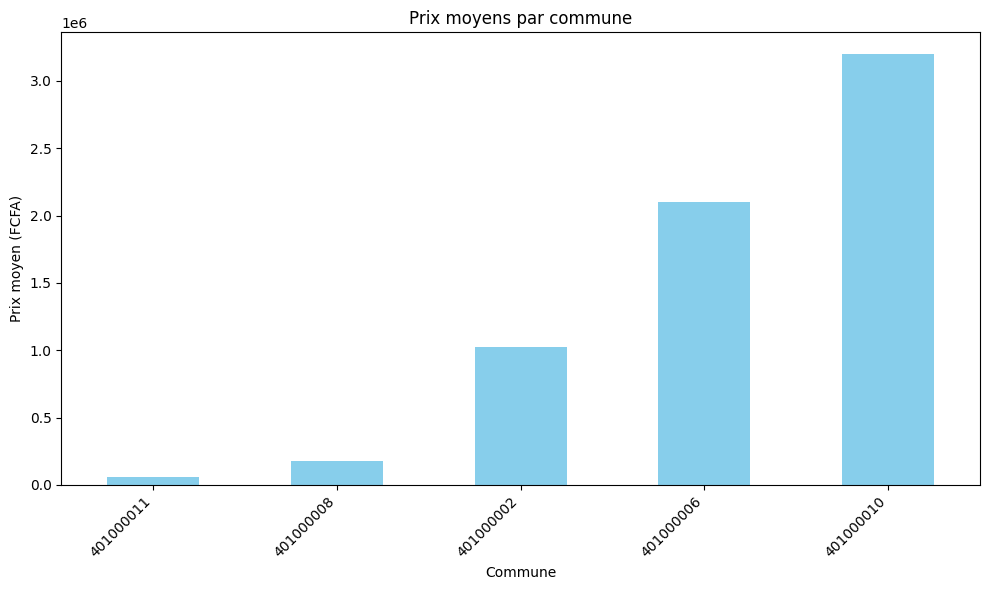

In [147]:
# Calculer les prix moyens par commune
prix_moyens_par_commune = df.groupby("code_var 2014")['price'].mean().sort_values()

# Afficher les prix moyens par commune
print(prix_moyens_par_commune)


# Créer un graphique en barres
plt.figure(figsize=(10, 6))
prix_moyens_par_commune.plot(kind='bar', color='skyblue')

# Ajouter un titre et des labels
plt.title('Prix moyens par commune')
plt.xlabel('Commune')
plt.ylabel('Prix moyen (FCFA)')
plt.xticks(rotation=45, ha='right')

# Afficher le graphique
plt.tight_layout()
plt.show()
